# Concise Implementation of Linear Regression


* Goal: implement the linear regression model concisely by using high-level APIs of deep learning frameworks
* Modern libraries implement useful "routine" components: data iterators, loss functions, optimizers, and neural network layers

Preliminaries:

In [1]:
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

In [2]:
import collections
import hashlib
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

## Generating the Dataset

We generate the synthetic dataset according to linear model with additive noise:
- first, we'd better define a function for producing datasets, so it can be reused

In [3]:
def synthetic_data(w, b, num_examples):
    """ Generate y = Xw + b + noise """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))



* then, start generating the dataset:

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

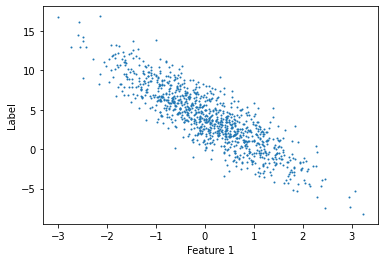

In [5]:
plt.scatter(features[:, 1], labels, 1);
plt.xlabel('Feature 1')
plt.ylabel('Label');

## PyTorch's Dataset and DataLoader classes
As the name suggests, a **Dataset** object describes the dataset: some data, its size and how to get its examples.
 - A Dataset object, let's say `D`, has the private dunder methods `__len__` and `__getitem__`; we can then use the corresponding public functionalities:
   - `len(D)`: retrieves the dataset size
   - `D[k]`: the item of `D` at index position `k`

A **DataLoader** object is an *iterable object* wrapping around a dataset, to basically allow for fetching chunks (batches) of the dataset, one at a time. It also specifies:
 - the size of each batch
 - whether the examples will be provided in shuffled order, or the provided batches span the dataset's examples in the original order
   - shuffling is necessary for the training set, unnecessary for the test set

Schematically:

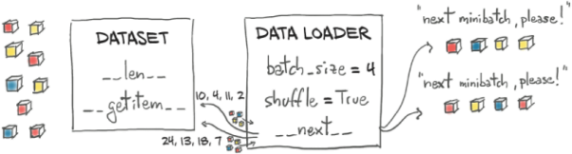

Notice: actually the DataLoader object is iterable, so it has `__iter__` but no `__next__`.
- `next(...)` works after building the iterator: e.g. `next(iter(D))`

## Reading the Dataset
  

We define the useful function ```load_array()``` based on PyTorch `data` module: it takes the dataset and the batch size ($|\beta|$), and returns an iterable object allowing to iterate through the dataset
 - `is_train` boolean argument indicates whether the iterator must shuffle the data on every epoch (unneeded for test phase)

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterable."""
    dataset = data.TensorDataset(*data_arrays) # Notice: *data_arrays is an unpacking. TensorDataset is a subclass of Dataset specifically for tensor data
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

* Let us construct the iterator and check out the first data example


In [8]:
next(iter(data_iter))

[tensor([[-0.5074,  1.0978],
         [ 1.1979, -1.4696],
         [ 0.2333,  0.3285],
         [-0.5578, -0.9096],
         [ 1.4228,  0.9501],
         [-0.4431,  0.5005],
         [-0.6373,  0.4277],
         [-0.9981,  0.8678],
         [ 0.7991, -0.3827],
         [ 0.3217, -0.2661]]),
 tensor([[-0.5305],
         [11.5874],
         [ 3.5484],
         [ 6.1839],
         [ 3.8229],
         [ 1.6150],
         [ 1.4783],
         [-0.7508],
         [ 7.0923],
         [ 5.7405]])]

## Defining the Model

*  A model is a sequence of layers.
    * `Sequential` is a class that defines a **container** for several layers chained together: a layer's outputs are wired to inputs of successive layer
       - just list the layers as arguments for the constructor call
    * `Linear` class is used in  PyTorch to define a linear or fully-connected **layer**
       - 2 arguments: input feature dimension, output feature dimension

Continuing previous example, let us define a network for the linear model, i.e. a 1 layer NN
 - the `Sequential` container is not really needed (for a single layer), but will always be used later on

In [9]:
net = nn.Sequential(nn.Linear(2, 1))

* the assigned object represents a NN: can be indexed to get the layers
  - `net[0]` will locate the layer of interest (zero-based index): first layer in this case

## Initializing Model Parameters

* `weight` and `bias` attributes represent the parameters
   - both have `.data` attribute to access the value(s)


Deep learning frameworks often have a predefined way to initialize the parameters: see Xavier Glorot initialization at https://pytorch.org/docs/stable/nn.init.html

Here, we initialize the parameters
 - $w_i \sim \textit N(0,0.01^2)$ for all $i$ independently
 - $b=0$


In [10]:
print(net[0].weight.data.normal_(0, 0.01))
print(net[0].bias.data.fill_(0))

tensor([[0.0111, 0.0163]])
tensor([0.])


## Defining the Loss Function


The `MSELoss` class computes the mean squared error, that is the sum of squared errors (also called squared $L_2$ norm) divided by the sample size.
 - it refers to formula with the average loss over examples by default: behaviour can be changed


In [11]:
loss = nn.MSELoss()

## Defining the Optimization Algorithm


PyTorch has several algorithm variations for optimizing NNs, in the `optim` module
 - an `SGD` class instance represents the SGD optimizer algorithm: it must know the network parameters and any required hyperparameter's value
    - `net.parameters()`
    - learning rate ```lr``` for SGD is required
    - What about the batch size of Minibatch SGD?

In [12]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

* For some number of epochs:
    * make a complete pass over the dataset (`train_data`), iteratively grabbing one minibatch of inputs and labels.
    * For each minibatch
        * Generate predictions by calling `net(X)` (this is the forward computation) and calculate the loss `l`.
        * Calculate gradients by running the backpropagation.
        * Update the model parameters by invoking our optimizer.


In [13]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad() # To avoid accumulating the gradients on subsequent backward passes
        l.backward()
        trainer.step() # explicitly perform one iteration
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000432
epoch 2, loss 0.000094
epoch 3, loss 0.000094
epoch 4, loss 0.000094
epoch 5, loss 0.000094
epoch 6, loss 0.000094
epoch 7, loss 0.000094
epoch 8, loss 0.000094
epoch 9, loss 0.000094
epoch 10, loss 0.000094


## Comparison between learnt and actual parameters


For post-hoc check, we compare the model parameters learned by training on finite data and the actual (ground-truth) parameters that generated our synthetic dataset.
 - first access the layer by indexing `net`, then access layer's parameters

In [14]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([7.3910e-05, 3.9577e-05])
error in estimating b: tensor([6.1035e-05])


## Summary


* Using PyTorch's high-level APIs, we can implement models much more concisely.
* In PyTorch, the `data` module provides tools for data processing, the `nn` module defines a large number of neural network layers and common loss functions.
* We can initialize the parameters by replacing their values with methods ending with `_`.

## Exercises

1. Review the PyTorch documentation to see what loss functions and initialization methods are provided. Replace the loss by Huber's loss.
1. How do you access the gradient of `net[0].weight`?



## Solutions:


1. Search PyTorch documentation you can find the HuberLoss function. So, replace:

In [ ]:
loss = nn.HuberLoss()

2. By the code snippet:

In [ ]:
net[0].weight.grad

tensor([[0.0020, 0.0020]])

In [ ]:
net

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)